In [33]:
import msprime
import numpy as np
from IPython.display import SVG, display

In [30]:
# константы 

# С другими параметрами уже ощутимо дольше
L_HUMAN = 3_0_000_000
RHO_HUMAN = 1.6*10e-9
MU_HUMAN = 1.25*10e-8

RHO_LIMIT = (1.6*10e-10, 1.6*10e-8)
MU_LIMIT = (1.25*10e-7, 1.25*10e-9)

NUMBER_OF_EVENTS_LIMITS = (1, 20)
LAMBDA_EXP = 20_000

POPULATION = 10_000
POPULATION_COEFF_LIMITS = (0.5, 1.5)
MIN_POPULATION_NUM = 1_000


In [ ]:
# Это пока не используем, берем константы 

def give_rho() -> float:
    return np.random.uniform(*RHO_LIMIT)


def give_mu() -> float:
    return np.random.uniform(*MU_LIMIT)


def give_random_coeff(mean=.128, var=.05) -> float:
    return np.random.beta(.1, .028)*.0128


def give_random_rho(base=RHO_HUMAN) -> float:
    return np.random.uniform(0.0001, 100, 1)[0]*base

In [31]:
# Генератор демографических событий 

def generate_demographic_events(population: int = POPULATION) -> 'msprime.Demography':
    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=population)

    # Определяем число случайных ссобыытий в прошлом - от 1 до 20
    number_of_events = np.random.randint(*NUMBER_OF_EVENTS_LIMITS)

    # А теперь случайно нагенерим им время и отсортруем его (посторим вариацонный ряд?)
    # Просто чтоб логично было, думаю msprime если что сам отсортрует - TODO протестировать гипотезу 
    times = sorted(np.random.exponential(LAMBDA_EXP, size=number_of_events))

    # Это чтоб размер популции плссал нее около начального, а около последнего случайного
    # Думаю так честнее
    # Предеделы POPULATION_COEFF_LIMITS = (0.5, 1.5) и MIN_POPULATION_NUM = 1_000
    last_population_size = population
    for t in times:
        last_population_size = max(last_population_size * np.random.uniform(*POPULATION_COEFF_LIMITS),
                                   MIN_POPULATION_NUM)
        demography.add_population_parameters_change(
            t, initial_size=last_population_size)

    return demography

In [ ]:
# Это разбиватель прошого на куски - тут самый простой, константный, который режит прошлое на 
# куски размером 5_000 поколений - можно хитрее, подйодет любая неубывающая функция из R^+ -> {0,1,2,...N-1}
# Но такая функция себя тоже нормально показывает, не дает вырожденного распределения в один интервал 
def simple_split(time: float, N: int, split_const: int = 5000) -> int:
    return int(min(time//split_const, N-1))

In [ ]:
# Сам генератор - самое интересное

class DataGenerator():
    def __init__(self,
                 recombination_rate: float = RHO_HUMAN,
                 mutation_rate: float = MU_HUMAN,
                 demographic_events: list = None,
                 population: int = None,
                 number_intervals: int = 20,
                 splitter=simple_split,  # maust be annotiede
                 num_replicates: int = 1,
                 lengt: int = L_HUMAN,
                 model: str = "hudson",
                 random_seed: int = 42,
                 sample_size: int = 2,
                 ):
        # Тут все технчиеское
        self.sample_size = sample_size
        self.recombination_rate = recombination_rate
        self.mutation_rate = mutation_rate
        self.num_replicates = num_replicates
        if not demographic_events:
            if not population:
                raise BaseException(
                    "Eiter demographic_events or population must be speciefied")
            demographic_events = msprime.Demography()
            demographic_events.add_population(
                name="A", initial_size=population)
        self.demographic_events = demographic_events
        self.splitter = splitter
        self.model = model
        self.len = lengt
        self.random_seed = random_seed
        self.number_intervals = number_intervals
        self._data = None

    def run_simulation(self):
        """
        return generator(tskit.TreeSequence)
        function run the simulation with given parametrs
        """
        # техническое
        self._data = msprime.sim_ancestry(
            recombination_rate=self.recombination_rate,
            sequence_length=self.len,
            num_replicates=self.num_replicates,
            demography = self.demographic_events,
            model=self.model,
            random_seed=self.random_seed,
            samples=self.sample_size)
        return self._data

    def __iter__(self):
        # техническое
        return self

    def __next__(self):
        """
        return haplotype, recombination points and coalescent time
        """
        # техническое
        if self._data is None:
            self.run_simulation()

        try:
            tree = next(self._data)
        except StopIteration:
            raise StopIteration

        # Инетерсное
        # Накидываем мутации - теперь они идут отдлеьно от рекомбаций
        mutated_ts = msprime.sim_mutations(
            tree, rate=self.mutation_rate)  # random_seed
        
        # генерим три списка, которые будут данными
        times = [0]*self.len
        mutations = [0]*self.len
        prior_dist = [0.0]*self.number_intervals
        
        # Получаем генном - в целом все просто, сначала у нас был вектор длины L из нулей, теперь мы раскидали по нему 1
        # там, где была мутация
        for m in mutated_ts.mutations():
            mutations[int(m.position)] = 1

        
        for t in mutated_ts.aslist():
            # Для каждого участка, пришедшего от одного предка
            # полуучаем интервалы участка 
            interval = t.get_interval()
            left = interval.left
            right = interval.right
            # и время - коэфицент 2 подобран эмпрически, ссмотря на дерево - чуть ниже объяснения
            time = t.get_total_branch_length()/2
            # Закинулы в ответ
            times[int(left):int(right)] = [time]*int(right-left)
            # Закинулы отсноистельную длину участка в необходимй интервал 
            prior_dist[self.splitter(
                time, self.number_intervals)] += (int(right-left))/self.len

        return mutations, prior_dist, times


In [5]:
# Немного объяснений почему так - с картинкам, для пущего убеждения

ts = msprime.sim_ancestry(
    samples=1,
    recombination_rate=1e-8,
    sequence_length=5_000,
    population_size=10_000,
    model="hudson",
    num_replicates=2,
    random_seed=42)

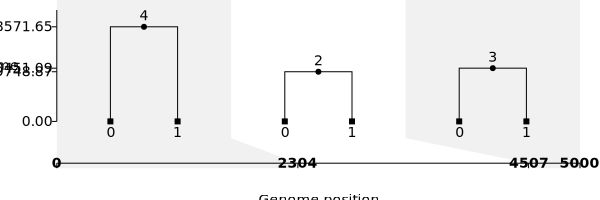

In [6]:
# То, что нам надо - но без мутаций
t = next(ts)
SVG(t.draw_svg(y_axis=True))


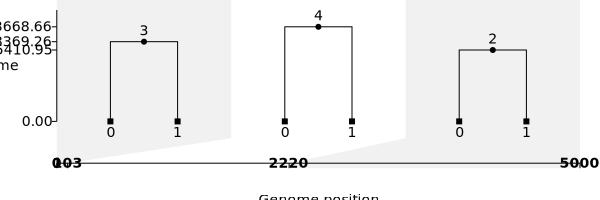

In [7]:
# второе что нам надо - но уже другое
t = next(ts)
SVG(t.draw_svg(y_axis=True))

In [8]:
# то, чот нам надо закончлось - так как мы поставли num_replicates=2
t = next(ts)
SVG(t.draw_svg(y_axis=True))

StopIteration: 

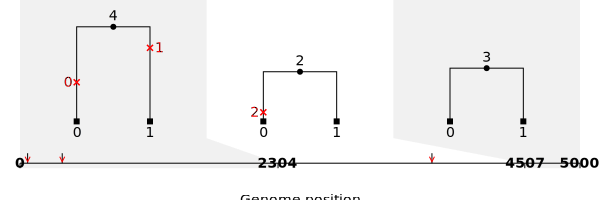

In [10]:
# Накнем мутаций
ts = msprime.sim_ancestry(
    samples=1,
    recombination_rate=1e-8,
    sequence_length=5_000,
    population_size=10_000,
    # ploidy=2,
    model="hudson",
    random_seed=42)
mutated_ts = msprime.sim_mutations(ts, rate=1e-8, random_seed=54321)
# Визуалзация шикарная
SVG(mutated_ts.draw_svg())

In [27]:
# Глянем на генератор с заданными деем ссобытями

demography = msprime.Demography()
demography.add_population(name="A", initial_size=10_000)
demography.add_population_parameters_change(2_000, initial_size =2_000)
demography.add_population_parameters_change(10_000, initial_size = 10_000)

L = 3_0_000_000
N = 20
### ####
ts = msprime.sim_ancestry(
    samples=1,
    recombination_rate=1e-8,
    sequence_length=L,
    # population_size=10_000,
    demography=demography,
    # ploidy=2,
    model="hudson",
    random_seed=42)

mutated_ts = msprime.sim_mutations(ts, rate=1e-8, random_seed=54321)

times = [0]*L
mutations = [0]*L
prior_dist = [0.0]*N

def simple_split(time: float, split_const: int = 5000) -> int:
    return int(min(time//split_const, N-1))


splitter = simple_split

for m in mutated_ts.mutations():
    mutations[int(m.position)] = 1
    
for t in mutated_ts.aslist():
    interval = t.get_interval()
    left = interval.left
    right = interval.right
    time = t.get_total_branch_length()/2
    times[int(left):int(right)] = [time]*int(right-left)
    prior_dist[splitter(time)] += (int(right-left))/L

In [28]:
prior_dist

[0.5545362666666668,
 0.31501256666666644,
 0.028784233333333336,
 0.02352593333333333,
 0.01958920000000001,
 0.015370333333333335,
 0.008557166666666668,
 0.0060410333333333335,
 0.007455533333333337,
 0.0047807,
 0.0033809333333333336,
 0.0032503333333333325,
 0.0011061333333333336,
 0.0019578666666666663,
 0.0009477999999999998,
 0.0012390000000000003,
 0.0008481666666666666,
 0.0009957666666666667,
 0.0002895666666666667,
 0.002331466666666667]

In [34]:
# случайне события - генерятся
random_demography = generate_demographic_events()
random_demography.debug()

,start,end,growth_rate
A,10000.0,10000.0,0
time,type,parameters,effect
4723,Population parameter change,"population=-1, initial_size=11537.399183494594",initial_size → 1.2e+04 for all populations
,start,end,growth_rate
A,11537.4,11537.4,0
time,type,parameters,effect
3.958e+04,Population parameter change,"population=-1, initial_size=9716.06411125586",initial_size → 9.7e+03 for all populations
,start,end,growth_rate
A,9716.1,9716.1,0


In [35]:
random_demography = generate_demographic_events()
random_demography.debug()

,start,end,growth_rate
A,10000.0,10000.0,0
time,type,parameters,effect
5277,Population parameter change,"population=-1, initial_size=13091.050776132706",initial_size → 1.3e+04 for all populations
,start,end,growth_rate
A,13091.1,13091.1,0


In [36]:
random_demography = generate_demographic_events()
random_demography.debug()

,start,end,growth_rate
A,10000.0,10000.0,0
time,type,parameters,effect
360.3,Population parameter change,"population=-1, initial_size=9075.402672831973",initial_size → 9.1e+03 for all populations
,start,end,growth_rate
A,9075.4,9075.4,0
time,type,parameters,effect
1155,Population parameter change,"population=-1, initial_size=10515.993489936878",initial_size → 1.1e+04 for all populations
,start,end,growth_rate
A,10516.0,10516.0,0
time,type,parameters,effect
